In [98]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.linalg import orthogonal_procrustes

[{'box': [317, 94, 55, 74], 'confidence': 0.9998021721839905, 'keypoints': {'left_eye': (333, 125), 'right_eye': (360, 123), 'nose': (351, 140), 'mouth_left': (337, 152), 'mouth_right': (360, 150)}}]
[{'box': [253, 214, 99, 117], 'confidence': 0.9997535347938538, 'keypoints': {'left_eye': (280, 255), 'right_eye': (329, 256), 'nose': (305, 271), 'mouth_left': (287, 300), 'mouth_right': (324, 300)}}, {'box': [426, 806, 26, 30], 'confidence': 0.7793079614639282, 'keypoints': {'left_eye': (436, 816), 'right_eye': (447, 817), 'nose': (442, 825), 'mouth_left': (436, 831), 'mouth_right': (445, 832)}}]


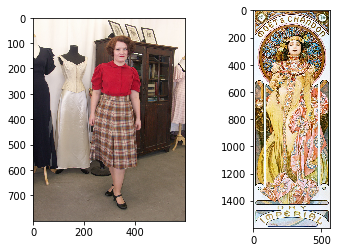

In [107]:
num = 3
file_c = '.\\Data\\c_'+str(num)+'.png'
picture_c = Image.open(file_c)
file_s = '.\\Data\\s_'+str(num)+'.png'
picture_s = Image.open(file_s)
face_c = open('.\\Data\\c_'+str(num)+'.txt', "r")
face_string_c = face_c.read()
face_string_c = "face_string_c = " + face_string_c

if face_string_c != 'face_string_c = ': 
    exec(face_string_c)
    print(face_string_c)
    keypoints_c = face_string_c[0]['keypoints']

else:
    print('No face here! Try different content image')

face_s = open('.\\Data\\s_'+str(num)+'.txt', "r")
face_string_s = face_s.read()
face_string_s = 'face_string_s = ' + face_string_s
if face_string_s != 'face_string_s = ': 
    exec(face_string_s)
    print(face_string_s)
    keypoints_s = face_string_s[0]['keypoints']

else:
    print('No faces here! Try different style image')

plt.subplot(1, 2, 1)
plt.imshow(picture_c)
plt.subplot(1, 2, 2)
plt.imshow(picture_s)     

# Transform

In [108]:
def procrustes(data1, data2):
    x1 = np.array(data1, dtype=np.double, copy=True)
    x2 = np.array(data2, dtype=np.double, copy=True)
    
    shift1 = np.mean(x1, 0)
    shift2 = np.mean(x2, 0) 
    x1 -= shift1
    x2 -= shift2

    scale1 = np.linalg.norm(x1)
    scale2 = np.linalg.norm(x2)
    x1 /= scale1
    x2 /= scale2

    R, s = orthogonal_procrustes(x1, x2)
    x2 = np.dot(x2, R.T) * s

    disparity = np.sum(np.square(x1 - x2))

    return shift1, shift2, scale1, scale2, R, s, x1, x2, disparity

In [109]:
def align(picture_c, picture_s, keypoints_c, keypoints_s):
    x_c = np.array([keypoints_c[name] for name in keypoints_c], dtype=np.double)
    x_s = np.array([keypoints_s[name] for name in keypoints_s], dtype=np.double)
    shift1, shift2, scale1, scale2, R, s, x_c_rot, x_s_rot, disparity = procrustes(x_c, x_s)
    angle = np.arccos(R[0,0])/np.pi*180
    scale = (scale1 /scale2) * s
    shift = shift1 - np.dot(shift2, R.T * (scale1 /scale2) * s)

    width_c, height_c = picture_c.size
    width_s, height_s = picture_s.size
    width_crop_c = min(shift1[0], width_c - shift1[0])
    height_crop_c = min(shift1[1], height_c - shift1[0])
    width_crop_s = min(shift2[0], width_s - shift2[0])
    height_crop_s = min(shift2[1], height_s - shift2[0])

    picture_c_proc = picture_c.crop((shift1[0] - width_crop_c, shift1[1] - height_crop_c, shift1[0] + width_crop_c, shift1[1] + height_crop_c))
    picture_s_proc = picture_s.crop((shift2[0] - width_crop_s, shift2[1] - height_crop_s, shift2[0] + width_crop_s, shift2[1] + height_crop_s))

    if scale > 1:
        picture_c_proc = picture_c_proc.resize(size = [int(picture_c_proc.size[0] / scale), int(picture_c_proc.size[1] / scale)])
    else:
        picture_s_proc = picture_s_proc.resize(size = [int(picture_s_proc.size[0] * scale), int(picture_s_proc.size[1] * scale)])

    width_c, height_c = picture_c_proc.size
    width_s, height_s = picture_s_proc.size
    width_crop = int((width_c - width_s)/2)
    width_crop_c = max(width_crop,0)
    width_crop_s = max(-width_crop,0)
    height_crop = int((height_c - height_s)/2)
    height_crop_c = max(height_crop,0)
    height_crop_s = max(-height_crop,0)

    picture_c_proc = picture_c_proc.crop((width_crop_c, height_crop_c, width_c - width_crop_c, height_c - height_crop_c))
    picture_s_proc = picture_s_proc.crop((width_crop_s, height_crop_s, width_s - width_crop_s, height_s - height_crop_s))

    picture_s_proc = picture_s_proc.rotate(-angle)

    plt.subplot(1, 2, 1)
    plt.imshow(picture_c_proc)  
    plt.subplot(1, 2, 2)
    plt.imshow(picture_s_proc) 
    
    return {'content': picture_c_proc, 'style': picture_s_proc}

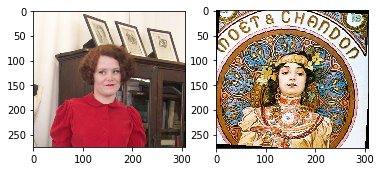

In [110]:
aligned = align(picture_c, picture_s, keypoints_c, keypoints_s)

In [106]:
aligned['content'].save('.\\Data\\c_'+str(num)+'_proc.png')
aligned['style'].save('.\\Data\\s_'+str(num)+'_proc.png')